## Construcción de nuevos predictores

In [1]:
library(dplyr)
library(forcats)
library(compare) 

Warning message:
"package 'dplyr' was built under R version 4.1.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'forcats' was built under R version 4.1.3"
Warning message:
"package 'compare' was built under R version 4.1.1"

Attaching package: 'compare'


The following object is masked from 'package:base':

    isTRUE




Se importa el csv que se obtuvo tras la selección y limpieza de observarciones.

In [2]:
dat <- read.csv("datos_limpios.csv")
dat <- subset(dat, dat$carrera == "IngenierÃ­a en Datos e Inteligencia Organizacional")
dat$X <- NULL
colnames(dat)[1] <- "matricula"
dat$carrera <- "Ingeniería en Datos e Inteligencia Organizacional"
nrow(dat)
head(dat)

[1] 16507

,matricula,carrera,periodo,clave,asignatura,docente,promediofinal,ceneval_global,ceneval_analitico,ceneval_matematico,ceneval_lengua,ceneval_esp,promedio
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,170300041,Ingeniería en Datos e Inteligencia Organizacional,202001,IL0414,Taller de argumentaciÃ³n y tÃ©cnicas de negociaciÃ³n,Torres PÃ©rez / RubÃ©n Juan,7,952,1056.312,1038.156,1068.49,1087.139,8.805714
2,180300332,Ingeniería en Datos e Inteligencia Organizacional,202001,II0422,Taller de emprendedores,Zapata SolÃ­s / Zuemy De Lourdes,8,1048,1056.312,1038.156,1068.49,1087.139,8.314452
3,170300110,Ingeniería en Datos e Inteligencia Organizacional,202001,DP0498,Problemas de MÃ©xico,DÃ­az Molina / Libertad Fidelina,9,1144,1056.312,1038.156,1068.49,1087.139,8.272397
4,190300691,Ingeniería en Datos e Inteligencia Organizacional,202001,IT0264,IntroducciÃ³n a los sistemas de informaciÃ³n,Olivares GonzÃ¡lez / Oscar,10,1072,1056.312,1038.156,1068.49,1087.139,8.014374
5,180300294,Ingeniería en Datos e Inteligencia Organizacional,202001,II0215,Electricidad y magnetismo,RamÃ­rez Carmona / Leslye Johanna,7,1018,1056.312,1038.156,1068.49,1087.139,7.198777
6,190300757,Ingeniería en Datos e Inteligencia Organizacional,202001,IT0264,IntroducciÃ³n a los sistemas de informaciÃ³n,SÃ¡nchez PÃ©rez / VÃ­ctor Leonel,10,1096,1056.312,1038.156,1068.49,1087.139,8.014374


In [3]:
dat$promedio <- NULL

### Creación de variable dependiente (aprobado)

Lo que se buscará predecir es si un estudiante aprobará o no una asignatura.

In [4]:
# Variable dependiente
dat$aprobado <- ifelse(dat$promediofinal > 6, 1, 0)

In [5]:
# Eliminamos observaciones con datos nulos
ind <- complete.cases(dat) 
dat <- dat[ind,]

### Creación  de nuevas variables

In [6]:
# Función para recorrer valores al siguiente periodo

move_values <- function(prev_col, value){
    matriculas <- unique(dat$matricula)
    dat$new_col <- 0
    for(mat in matriculas){
        carreras <- unique((dat %>% filter(matricula == mat))$carrera)
        for(car in carreras){ #en caso de que el estudiante haya cambiado de programa educativo
            aux <-c()
            aux <- append(aux, value) 
            periodos <- sort(unique((dat %>% filter(matricula == mat, carrera == car))$periodo))
            i <- 1
            for(periodo in periodos){
                aux <- append(aux, dat[dat$matricula==mat & dat$carrera==car & dat$periodo==periodo,][, prev_col][1])
                dat[dat$matricula==mat & dat$carrera==car & dat$periodo==periodo ,][,"new_col"] <- aux[i]
                i <- i + 1
            }
        }
    }
   
    return(dat)
}

Variables **prom_per_actual** y **prom_per_prev**

In [7]:
# Calcular promedio por periodo de cada estudiante
prom_periodo <- dat %>% group_by(matricula, carrera, periodo) %>% summarise(prom_per_actual = mean(promediofinal))

# Guardar variables en dataframe principal
dat <- merge(prom_periodo, dat, by=c("matricula","carrera","periodo"))

# Recorrer promedio de periodo a n al periodo n+1
dat <- move_values("prom_per_actual", median(dat$prom_per_actual))
dat <- rename(dat, prom_per_prev = new_col)

`summarise()` has grouped output by 'matricula', 'carrera'. You can override using the `.groups` argument.


Variable **tasa_rep_doc_asig**

In [8]:
# Tasa de reprobación de un docente por asignatura
data_doc_asig <- dat %>% group_by(docente, asignatura) %>% summarise(tasa_rep_doc_asig = (1-sum(aprobado)/n())*100)

# Guardar variables en dataframe principal
dat <- merge(dat, data_doc_asig)

`summarise()` has grouped output by 'docente'. You can override using the `.groups` argument.


Variables **tasa_rep_doc** y **cuartil_docente** 

In [9]:
# Tasa de reprobación general de un docente 
data_doc <- dat %>% group_by(docente) %>% summarise(tasa_rep_doc = (1-sum(aprobado)/n())*100)

# Segmentar docentes por cuartiles dependiendo su tasa de reprobación general
data_doc <- mutate(data_doc, cuartil_docente = ntile(tasa_rep_doc, 4))

# Guardar variables en dataframe principal
dat <- merge(dat, data_doc)

Variables **tasa_rep_asig, cuartil_asig, quintil_asig** y **decil_asig**

In [10]:
# Agregar campo con tasa de reprobación por asignatura 
rep_asig <- dat %>% group_by(clave) %>% summarise(tasa_rep_asig = (1-sum(aprobado)/n())*100)

# Agregar campo con el cuartil en el que se ubica una asig. basado en su tasa de reprobación
rep_asig <- mutate(rep_asig, cuartil_asig = ntile(tasa_rep_asig, 4))

# Agregar campo con el quintil en el que se ubica una asig. basado en su tasa de reprobación
rep_asig <- mutate(rep_asig, quintil_asig = ntile(tasa_rep_asig, 5))

# Agregar campo con el decil en el que se ubica una asig. basado en su tasa de reprobación
rep_asig <- mutate(rep_asig, decil_asig = ntile(tasa_rep_asig, 10))


In [11]:
quantile(rep_asig$tasa_rep_asig)

0%        25%        50%        75%       100% 
 0.0000000  0.4347826  5.8823529 11.9771252 41.8390805

Separar el último quintil de reprobación en dos grupos (*ver Notebook:* ***Complejidad de cargas con quintiles*** *del directorio* ***aprobado***).

In [12]:
quintil5 <- rep_asig %>% filter(quintil_asig == 5)

In [13]:
nrow(quintil5)
head(quintil5)

[1] 23

clave,tasa_rep_asig,cuartil_asig,quintil_asig,decil_asig
<chr>,<dbl>,<int>,<int>,<int>
DP0191,14.85944,4,5,9
DP0194,19.68811,4,5,9
ID0101,41.83908,4,5,10
ID0102,38.81579,4,5,10
ID0103,39.47368,4,5,10
ID0205,25.56054,4,5,10


In [14]:
quintil5_sort <- quintil5[order(quintil5$tasa_rep_asig),][1:23,]

In [15]:
head(quintil5_sort)

clave,tasa_rep_asig,cuartil_asig,quintil_asig,decil_asig
<chr>,<dbl>,<int>,<int>,<int>
LI0110,14.22594,4,5,9
IT0210,14.83516,4,5,9
DP0191,14.85944,4,5,9
IT0208,15.32847,4,5,9
LI1101,16.78322,4,5,9
ID0263,16.90141,4,5,9


In [16]:
quintil5_sort$quintil_asig <- as.double(quintil5_sort$quintil_asig)
quintil5_sort[1:11,]$quintil_asig <- 5.1   # con 5.1 se identifica la primera mitad del último quintil
quintil5_sort[12:23,]$quintil_asig <- 5.2 # con 5.2 se identifica la segunda mitad del último quintil

In [17]:
quintil5_sort[11:12,] # 22.55 es tope de 90% (primera mitad del quinto quintil)

clave,tasa_rep_asig,cuartil_asig,quintil_asig,decil_asig
<chr>,<dbl>,<int>,<dbl>,<int>
ID0309,20.11173,4,5.1,9
TA0030,20.58824,4,5.2,9


In [18]:
rep_asig <- rep_asig %>% filter(quintil_asig < 5)

In [19]:
nrow(rep_asig)
head(rep_asig)
unique(rep_asig$quintil_asig)

[1] 96

clave,tasa_rep_asig,cuartil_asig,quintil_asig,decil_asig
<chr>,<dbl>,<int>,<int>,<int>
AD0001,0.000000,1,1,1
AD0002,0.000000,1,1,1
AD0003,5.882353,2,3,5
AD0007,0.000000,1,1,1
AD0010,3.846154,2,2,4
AD0011,0.000000,1,1,1


[1] 1 3 2 4

In [20]:
rep_asig <- rbind(rep_asig, quintil5_sort)

In [21]:
nrow(rep_asig)

[1] 119

In [22]:
# Guardar variables en dataframe principal
dat <- merge(rep_asig, dat, by="clave")

Variables **cantidad_asig** y **tasa_rep_carga**

La variable *cantidad_asig* indica el número de asignaturas que un estudiante esta cursando en cierto semestre.

La variable *tasa_rep_carga* indica la tasa de reprobación de la carga académica del estudiante. Este campo nos sirve para tener un índice que refleje la dificultad de dicha carga.



In [23]:
# Además de agrupar por matricula y periodo, se agrupa por carrera en caso de que cambiara de programa educativo
asig_periodo <- dat %>% group_by(matricula, carrera, periodo) %>% summarise(cantidad_asig = n(), tasa_rep_carga = mean(tasa_rep_asig))
dat <- merge(asig_periodo, dat, by=c("matricula", "carrera", "periodo"))

`summarise()` has grouped output by 'matricula', 'carrera'. You can override using the `.groups` argument.


Variables **año** y **semestre**

Surgen de la variable *periodo*, ya que ésta no es una variable apta para la creación del modelo per se.

En la siguiente celda, *semestre* queda con valores categóricos 1 y 3, pero después de la creación de *recursada* sus valores cambian a Primavera y Otoño.

In [24]:
# Separar año y periodo para guardarlos en distintas variables
dat$año <- as.integer(round(dat$periodo/100))
dat$semestre <- as.integer(round(dat$periodo%%100))
dat$semestre <- factor(dat$semestre, levels = c("1", "3"), ordered=T)

Variable **recursada**

In [25]:
# Variable binaria que indica si es primera vez que cursa la materia o no. (0 = primera vez, 1 = recursada)

asig <- distinct(dat, carrera, matricula, clave, año, semestre)
asig <- asig[order(asig$año, asig$semestre),]
asig$recursada <- ifelse(duplicated(asig[,1:3])==TRUE, 1, 0)
dat <- merge(asig, dat, by=c("matricula", "carrera","clave", "año", "semestre"))

dat$semestre <- recode_factor(dat$semestre, "1"="Primavera", "3"="Otoño")


Variable **generacion**

In [26]:
# Agregar campo con el año en el que ingresó el estudiante a la universidad
dat$generacion <- as.integer(substr(dat$matricula, 1, 2)) + 2000
dat$generacion[dat$generacion == 2080] <- 2008
dat$generacion[dat$generacion == 2090] <- 2009


Variable **tasa_aprob_per**

Necesaria para la creación de *tasa_aprob_per_prev*.

In [27]:
# Agregar campo con tasa de aprobación que tiene el estudiante en asignaturas de cuartil 4 durante el periodo
aprob_asig_per <- dat %>% group_by(matricula, carrera, periodo) %>% filter(cuartil_asig==4) %>% summarise(tasa_aprob_per = mean(aprobado))
aprob_asig_per <- merge(dat, aprob_asig_per, by=c("matricula", "carrera", "periodo"))

dif <- anti_join(dat,aprob_asig_per)
dif$tasa_aprob_per <- median(aprob_asig_per$tasa_aprob_per) 

dat <- rbind(dif, aprob_asig_per)

`summarise()` has grouped output by 'matricula', 'carrera'. You can override using the `.groups` argument.
Joining, by = c("matricula", "carrera", "clave", "año", "semestre", "recursada", "periodo", "cantidad_asig",
"tasa_rep_carga", "tasa_rep_asig", "cuartil_asig", "quintil_asig", "decil_asig", "docente", "asignatura",
"prom_per_actual", "promediofinal", "ceneval_global", "ceneval_analitico", "ceneval_matematico", "ceneval_lengua",
"ceneval_esp", "aprobado", "prom_per_prev", "tasa_rep_doc_asig", "tasa_rep_doc", "cuartil_docente", "generacion")


Variable **tasa_aprob_per_prev**

In [28]:
dat <- move_values("tasa_aprob_per", 0)
dat <- rename(dat, tasa_aprob_per_prev = new_col)

Variable **tasa_aprob_gral**

In [29]:
# Agregar campo con tasa de aprobación general de un estudiante en asignaturas de cuartil 4
aprob_asig_gral <- dat %>% group_by(matricula, carrera) %>% filter(cuartil_asig==4) %>% summarise(tasa_aprob_gral = mean(aprobado))

aprob_asig_gral <- merge(dat, aprob_asig_gral, by=c("matricula", "carrera"))

dif <- anti_join(dat,aprob_asig_gral)

#dif$tasa_aprob_gral <- median(aprob_asig_gral$tasa_aprob_gral) 

dat <- rbind(dif, aprob_asig_gral)


`summarise()` has grouped output by 'matricula'. You can override using the `.groups` argument.
Joining, by = c("matricula", "carrera", "clave", "año", "semestre", "recursada", "periodo", "cantidad_asig",
"tasa_rep_carga", "tasa_rep_asig", "cuartil_asig", "quintil_asig", "decil_asig", "docente", "asignatura",
"prom_per_actual", "promediofinal", "ceneval_global", "ceneval_analitico", "ceneval_matematico", "ceneval_lengua",
"ceneval_esp", "aprobado", "prom_per_prev", "tasa_rep_doc_asig", "tasa_rep_doc", "cuartil_docente", "generacion",
"tasa_aprob_per", "tasa_aprob_per_prev")


Variable **tasa_aprob_gral_prev**

Esta variable guarda el promedio de tasa de aprobación (en asignaturas del cuarto cuartil de reprobación) general que un estudiante tiene al momento de cursar cierta asignatura, es decir, el promedio de aprobación que tiene hasta el periodo previo.

In [30]:
matriculas <- unique(dat$matricula)
    dat$tasa_aprob_gral_prev <- 0
    for(mat in matriculas){
        carreras <- unique((dat %>% filter(matricula == mat))$carrera)
        for(car in carreras){ #en caso de que el estudiante haya cambiado de programa educativo
            tasa_aprob <- c()
            prom <-c()
            prom <- append(prom, 0) # En primer semestre no se tiene tasa de aprobación 
            periodos <- sort(unique((dat %>% filter(matricula == mat, carrera == car))$periodo))
            i <- 1
            for(periodo in periodos){
                # Hacer arreglo de tasa de aprobación por periodo
                tasa_aprob <- append(tasa_aprob, dat[dat$matricula==mat & dat$carrera==car & dat$periodo==periodo,][, "tasa_aprob_per"][1])
                # Calcular promedio general de aprobación
                prom <- append(prom, mean(tasa_aprob))
                dat[dat$matricula==mat & dat$carrera==car & dat$periodo==periodo,][,"tasa_aprob_gral_prev"] <- prom[i]
                i <- i + 1        
            }
        }
    }

In [31]:
matriculas <- unique(dat$matricula)
    dat$tasa_aprob_gral_prev <- 0
    for(mat in matriculas){
        carreras <- unique((dat %>% filter(matricula == mat))$carrera)
        for(car in carreras){ #en caso de que el estudiante haya cambiado de programa educativo
            tasa_aprob <- c()
            prom <-c()
            prom <- append(prom, 0) # En primer semestre no se tiene tasa de aprobación 
            periodos <- sort(unique((dat %>% filter(matricula == mat, carrera == car))$periodo))
            i <- 1
            for(periodo in periodos){
                # Hacer arreglo de tasa de aprobación por periodo
                tasa_aprob <- append(tasa_aprob, dat[dat$matricula==mat & dat$carrera==car & dat$periodo==periodo,][, "tasa_aprob_per"][1])
                # Calcular promedio general de aprobación
                prom <- append(prom, mean(tasa_aprob))
                dat[dat$matricula==mat & dat$carrera==car & dat$periodo==periodo,][,"tasa_aprob_gral_prev"] <- prom[i]
                i <- i + 1        
            }
        }
    }

Variables **numRep** y **numRepPrev**

In [32]:
# Variable numérica que indica el número de materias que el alumno reprobó en un dado periodo.
asig2 <- dat %>% group_by(matricula, carrera, periodo) %>% summarise(numRep = length(aprobado[aprobado==0]))
dat <- merge(asig2, dat, by=c("matricula", "carrera","periodo"))

# Recorrer promedio de periodo a n al periodo n+1
dat <- move_values("numRep", 0)
dat <- rename(dat, numRepPrev = new_col)

`summarise()` has grouped output by 'matricula', 'carrera'. You can override using the `.groups` argument.


Variable **asigMuchas**

Variable binaria que indica si el número de materias cargadas en dicho periodo rebasa o no el promedio de materias cargadas por periodo. (1 = rebasa promedio, 0 = no rebasa promedio)

In [33]:
mean(dat$cantidad_asig)
dat$asigMuchas <- ifelse(dat$cantidad_asig > 6, 1,0)

[1] 6.510632

Variable **cuartil_repEst**

Variable ordinal que clasifica al alumno con respecto al número de asignaturas que ha reprobado en el periodo previo.

In [34]:
repEst <- distinct(dat, matricula, carrera, periodo, numRepPrev)
repEst <- mutate(repEst, cuartil_repEst = ntile(numRepPrev, 4))
dat <- merge(dat, repEst, by=c("matricula", "periodo", "carrera", "numRepPrev"))

In [35]:
quantile(repEst$numRepPrev)

0%  25%  50%  75% 100% 
   0    0    0    1    8

Variable **asigRep_totalAsig**

Variable numérica que indica la razón de materias reprobadas con respecto a materias cursadas durante toda la trayectoria del alumno. Los de nuevo ingreso/primer semestre registrado empiezan con $0$.

In [36]:
matriculas <- unique(dat$matricula)
    dat$asigRep_totalAsig <- 0
    for(mat in matriculas){
        carreras <- unique((dat %>% filter(matricula == mat))$carrera)
        for(car in carreras){ #en caso de que el estudiante haya cambiado de programa educativo
            actual <- c()
            prev <-c()
            prev <- append(prev, 0) 
            periodos <- sort(unique((dat %>% filter(matricula == mat, carrera == car))$periodo))
            i <- 1
            for(periodo in periodos){
                numRep <- dat[dat$matricula==mat & dat$carrera == car & dat$periodo==periodo,][, "numRep"][1]
                cantidad_asig <- dat[dat$matricula==mat & dat$carrera == car & dat$periodo==periodo,][, "cantidad_asig"][1]
                actual <- append(actual, (numRep/cantidad_asig))
                prev <- append(prev, actual[i])
                dat[dat$matricula==mat & dat$carrera == car & dat$periodo==periodo,][,"asigRep_totalAsig"] <- prev[i]
                i <- i + 1        
            }
        }
    }

Variable **año_encurso**

In [37]:
dat$año_encurso <- dat$año - dat$generacion + 1 

## Variables que representen el tipo de carga

### Usando cuartil_asig

* Representar cada carga académica con un vector indicando el total de asignaturas de cada cuartil de reprobación (cada carga se transformaría entonces en un vector de 4 componentes).

In [38]:
library(factoextra)
library(NbClust)

Warning message:
"package 'factoextra' was built under R version 4.1.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Warning message:
"package 'NbClust' was built under R version 4.1.3"


In [39]:
cargas_estudiantes <- as.data.frame(dat %>% group_by(matricula, carrera,periodo) %>% summarise(
    q1 = length(cuartil_asig[cuartil_asig==1]), q2 = length(cuartil_asig[cuartil_asig==2]),
    q3 = length(cuartil_asig[cuartil_asig==3]), q4 = length(cuartil_asig[cuartil_asig==4])))

vector_carga <- cargas_estudiantes %>% select(-matricula,-carrera,-periodo)

`summarise()` has grouped output by 'matricula', 'carrera'. You can override using the `.groups` argument.


In [40]:
nrow(vector_carga)

[1] 2805

* Aplicar k-medias o clusterización jerárquica, siguiendo algún criterio adecuado para la elección del total de grupos.

Se optó por usar únicamente k-medias:

Variable **complejidad_carga**

K-means clustering with 4 clusters of sizes 835, 640, 590, 740

Cluster means:
         q1        q2        q3       q4
1 0.1377246 0.7640719 2.6059880 3.258683
2 0.0390625 0.0953125 0.8312500 6.315625
3 0.5677966 2.9237288 1.3932203 1.218644
4 0.1635135 0.5148649 0.9108108 1.918919

Clustering vector:
   [1] 4 4 4 1 1 3 3 3 3 3 4 1 1 4 2 4 1 4 4 4 1 1 3 3 3 3 4 4 4 4 4 4 3 3 3 3 4
  [38] 1 4 4 4 4 3 4 3 4 3 4 4 4 1 3 3 3 3 4 4 4 4 4 3 3 3 4 4 3 4 4 4 1 1 1 1 1
  [75] 3 3 3 3 4 3 4 4 4 4 3 3 3 3 3 3 4 4 1 4 1 3 4 4 4 4 4 4 4 4 1 1 1 1 1 3 3
 [112] 3 3 3 1 1 4 4 1 3 4 3 3 4 4 1 4 1 4 4 4 3 3 3 3 4 4 4 4 4 4 3 4 3 3 3 3 4
 [149] 4 4 1 1 1 4 1 3 3 3 3 4 2 1 4 1 4 3 3 3 4 3 1 2 4 4 1 3 3 3 3 4 3 4 1 4 4
 [186] 4 3 4 3 3 3 1 4 3 1 4 3 3 3 3 4 3 4 4 4 4 4 4 1 3 4 3 4 3 3 4 4 1 4 1 1 4
 [223] 3 4 4 3 4 1 4 4 1 1 3 3 3 3 3 3 4 4 4 4 4 3 1 3 3 3 4 4 1 2 1 4 4 3 3 4 3
 [260] 4 4 4 2 1 4 4 4 3 4 4 4 3 3 4 3 4 4 2 4 1 1 4 3 3 4 3 3 3 4 2 4 2 2 2 2 2
 [297] 1 4 2 1 1 2 2 1 4 3 1 1 3 3 3 3 4 2 2 1 4

[1] 835 640 590 740

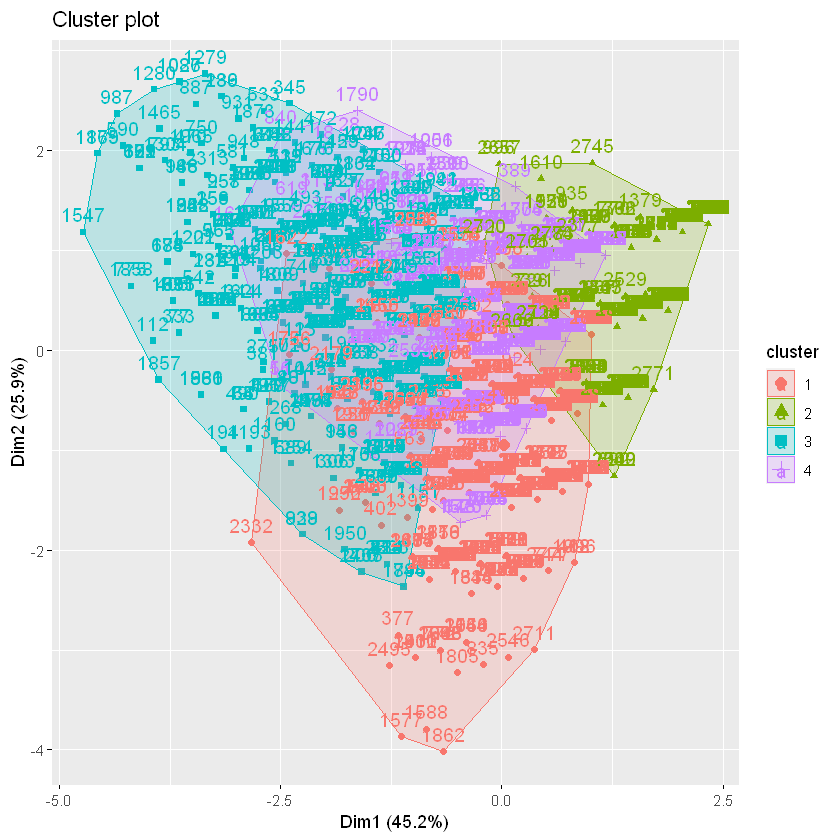

In [41]:
set.seed(123)

# Elbow method
#fviz_nbclust(vector_carga, kmeans, method = "wss") +
#  geom_vline(xintercept = 4, linetype = 2)+
#  labs(subtitle = "Elbow method") #k=4

# Silhouette method
#fviz_nbclust(vector_carga, kmeans, method = "silhouette")+
#  labs(subtitle = "Silhouette method") #k=6

km.res <- kmeans(vector_carga, 4, nstart = 100) # se usará la k dada por el primer método
print(km.res)
km.res$size # Cluster size

cargas_estudiantes <- cbind(cargas_estudiantes, complejidad_carga4 = km.res$cluster)

fviz_cluster(km.res, data = vector_carga)

In [42]:
# Características de los grupos formados por k-medias con k=4
km.res$centers 

,q1,q2,q3,q4
1,0.1377246,0.7640719,2.6059880,3.258683
2,0.0390625,0.0953125,0.8312500,6.315625
3,0.5677966,2.9237288,1.3932203,1.218644
4,0.1635135,0.5148649,0.9108108,1.918919


In [43]:
for(i in 1:4){
    print(paste("núm. asignaturas en k", i,"=",sum(km.res$centers[i,])))
}

[1] "núm. asignaturas en k 1 = 6.76646706586826"
[1] "núm. asignaturas en k 2 = 7.28125"
[1] "núm. asignaturas en k 3 = 6.10338983050847"
[1] "núm. asignaturas en k 4 = 3.50810810810811"


Tomando en cuenta los centroides de cada grupo, el orden de los niveles de complejidad de las cargas sería el siguiente:


* nivel 1 = grupo 4
* nivel 2 = grupo 3
* nivel 3 = grupo 2
* nivel 4 = grupo 1

*(Análisis y ajustes de la variable realizados manualmente).*

In [44]:
dat

matricula,periodo,carrera,numRepPrev,numRep,clave,año,semestre,recursada,cantidad_asig,...,cuartil_docente,generacion,tasa_aprob_per,tasa_aprob_per_prev,tasa_aprob_gral,tasa_aprob_gral_prev,asigMuchas,cuartil_repEst,asigRep_totalAsig,año_encurso
<int>,<int>,<chr>,<dbl>,<int>,<chr>,<int>,<fct>,<dbl>,<int>,...,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
140299892,201601,Ingeniería en Datos e Inteligencia Organizacional,0,0,II0322,2016,Primavera,0,4,...,4,2014,1,0,1,0,0,1,0,3
140299892,201601,Ingeniería en Datos e Inteligencia Organizacional,0,0,IT0105,2016,Primavera,0,4,...,4,2014,1,0,1,0,0,1,0,3
140299892,201601,Ingeniería en Datos e Inteligencia Organizacional,0,0,IT0106,2016,Primavera,0,4,...,2,2014,1,0,1,0,0,1,0,3
140299892,201601,Ingeniería en Datos e Inteligencia Organizacional,0,0,TA0011,2016,Primavera,0,4,...,2,2014,1,0,1,0,0,1,0,3
140299892,201603,Ingeniería en Datos e Inteligencia Organizacional,0,0,IT0107,2016,Otoño,0,3,...,4,2014,1,1,1,1,0,1,0,3
140299892,201603,Ingeniería en Datos e Inteligencia Organizacional,0,0,IT0208,2016,Otoño,0,3,...,4,2014,1,1,1,1,0,1,0,3
140299892,201603,Ingeniería en Datos e Inteligencia Organizacional,0,0,IT0264,2016,Otoño,0,3,...,3,2014,1,1,1,1,0,1,0,3
140299892,201701,Ingeniería en Datos e Inteligencia Organizacional,0,0,IT0263,2017,Primavera,0,3,...,4,2014,1,1,1,1,0,1,0,4
140299892,201701,Ingeniería en Datos e Inteligencia Organizacional,0,0,II0320,2017,Primavera,0,3,...,4,2014,1,1,1,1,0,1,0,4


In [45]:
# Guardar nuevas variables en dataframe principal
dat <- merge(dat, cargas_estudiantes, by=c("matricula","carrera","periodo"))
dat <- dat %>% select(-q1,-q2,-q3,-q4)

Ordenar valores categóricos de la variable **complejidad_carga4** de acuerdo a la dificultad del grupo

In [46]:
dat$complejidad_carga[dat$complejidad_carga4 == 4] <- 5 #nivel 1
dat$complejidad_carga[dat$complejidad_carga4 == 3] <- 6 #nivel 2
dat$complejidad_carga[dat$complejidad_carga4 == 1] <- 7 #nivel 3
dat$complejidad_carga[dat$complejidad_carga4 == 2] <- 8 #nivel 4

In [47]:
for(i in 5:8){
    dat$complejidad_carga[dat$complejidad_carga4 == i] <- i-4
}

### Usando quintil_asig

In [48]:
cargas_estudiantes5 <- as.data.frame(dat %>% group_by(matricula, carrera, periodo) %>% summarise(
    q1 = length(quintil_asig[quintil_asig==1]), q2 = length(quintil_asig[quintil_asig==2]),
    q3 = length(quintil_asig[quintil_asig==3]), q4 = length(quintil_asig[quintil_asig==4]),
    q5_1 = length(quintil_asig[quintil_asig==5.1]), q5_2 = length(quintil_asig[quintil_asig==5.2])))

vector_carga5 <- cargas_estudiantes5 %>% select(-matricula,-carrera,-periodo)
nrow(vector_carga5)

`summarise()` has grouped output by 'matricula', 'carrera'. You can override using the `.groups` argument.


[1] 2805

K-means clustering with 5 clusters of sizes 593, 360, 450, 685, 717

Cluster means:
          q1         q2        q3        q4      q5_1      q5_2
1 0.09780776 0.18043845 0.6188870 3.1365936 0.4924115 2.0050590
2 0.21111111 0.50000000 2.4361111 1.2638889 0.7194444 1.0555556
3 0.63555556 2.57555556 1.1244444 0.9955556 0.7266667 0.3933333
4 0.02773723 0.07883212 0.1459854 1.5605839 1.8948905 3.4160584
5 0.16736402 0.34030683 0.4741980 1.0083682 0.7001395 0.9693166

Clustering vector:
   [1] 5 5 5 5 2 2 3 3 3 5 5 4 5 5 4 5 1 5 5 5 1 2 2 3 3 3 5 5 5 5 5 5 2 3 3 3 5
  [38] 5 5 5 5 5 3 5 3 5 5 5 5 5 5 2 5 3 3 5 5 5 5 5 2 3 3 5 5 5 5 5 5 5 1 2 5 5
  [75] 5 3 3 3 5 5 5 4 5 2 3 3 2 3 3 3 1 5 5 5 2 2 5 5 5 5 5 2 5 5 1 1 1 1 2 2 3
 [112] 3 2 5 1 1 2 4 1 2 5 3 3 5 5 1 2 5 5 5 1 3 2 3 2 5 5 1 2 5 5 3 5 3 3 3 2 5
 [149] 5 5 1 1 2 5 5 3 3 3 3 5 4 1 5 1 5 3 3 3 5 5 5 4 5 5 2 2 3 3 2 5 5 5 1 5 5
 [186] 5 2 5 3 5 3 1 5 2 1 5 2 3 3 3 5 3 5 5 5 5 5 5 2 2 5 3 5 3 3 5 5 1 1 2 1 5
 [223] 2 5 5 2 5 5 1 5 1 2

[1] 593 360 450 685 717

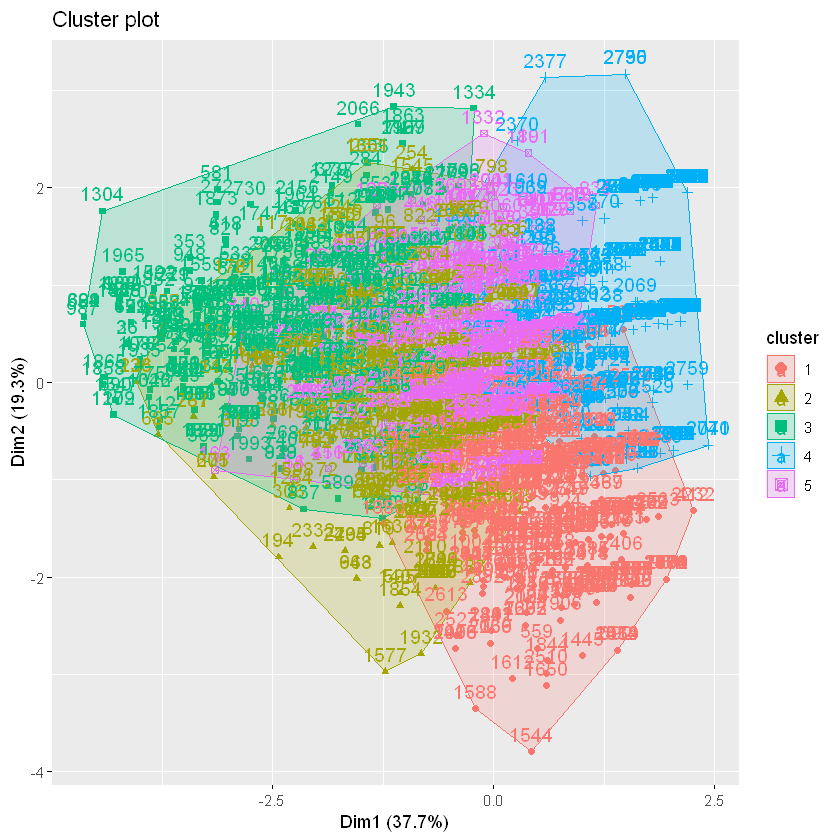

In [49]:
set.seed(123)

km.res <- kmeans(vector_carga5, 5, nstart = 100) # se usará la k dada por el método del codo
print(km.res)
km.res$size # Cluster size

cargas_estudiantes5 <- cbind(cargas_estudiantes5, complejidad_carga5 = km.res$cluster)

fviz_cluster(km.res, data = vector_carga5)

In [50]:
# Características de los grupos formados por k-medias con k=5
km.res$centers 

,q1,q2,q3,q4,q5_1,q5_2
1,0.09780776,0.18043845,0.6188870,3.1365936,0.4924115,2.0050590
2,0.21111111,0.50000000,2.4361111,1.2638889,0.7194444,1.0555556
3,0.63555556,2.57555556,1.1244444,0.9955556,0.7266667,0.3933333
4,0.02773723,0.07883212,0.1459854,1.5605839,1.8948905,3.4160584
5,0.16736402,0.34030683,0.4741980,1.0083682,0.7001395,0.9693166


In [51]:
for(i in 1:5){
    print(paste("núm. asignaturas en k", i, "=", sum(km.res$centers[i,]))) 
}

[1] "núm. asignaturas en k 1 = 6.53119730185498"
[1] "núm. asignaturas en k 2 = 6.18611111111111"
[1] "núm. asignaturas en k 3 = 6.45111111111111"
[1] "núm. asignaturas en k 4 = 7.12408759124088"
[1] "núm. asignaturas en k 5 = 3.65969316596932"


Tomando en cuenta los centroides de cada grupo, el orden de los niveles de complejidad de las cargas sería el siguiente:


* nivel 1 = grupo 5
* nivel 2 = grupo 1
* nivel 3 = grupo 2
* nivel 4 = grupo 4
* nivel 5 = grupo 3

*(Análisis y ajustes de la variable realizados manualmente).*

In [52]:
# Guardar nuevas variables en dataframe principal
dat <- merge(dat, cargas_estudiantes5, by=c("matricula","carrera","periodo"))
dat <- dat %>% select(-q1,-q2,-q3,-q4, -q5_1, -q5_2)

Ordenar valores categóricos de la variable **complejidad_carga5** de acuerdo a la dificultad del grupo

In [53]:
dat$complejidad_carga5[dat$complejidad_carga5 == 5] <- 6 #nivel 1
dat$complejidad_carga5[dat$complejidad_carga5 == 2] <- 7 #nivel 2
dat$complejidad_carga5[dat$complejidad_carga5 == 3] <- 8 #nivel 3
dat$complejidad_carga5[dat$complejidad_carga5 == 1] <- 9 #nivel 4
dat$complejidad_carga5[dat$complejidad_carga5 == 4] <- 10 #nivel 5

In [54]:
for(i in 6:10){
    dat$complejidad_carga5[dat$complejidad_carga5 == i] <- i-5
}

## Transformación de datos

### Dummy variables

Se hará uso de dummy variables para trabajar con los predictores *Carrera y Semestre*, ya que son categóricos. Se retira la primera dummy variable para evitar multicolinealidad en el modelo.

In [56]:
unique(dat$semestre)

[1] Primavera Otoño    
Levels: Primavera Otoño

In [58]:
library(fastDummies)

In [59]:
# carrera
#dat <- dummy_cols(dat, select_columns = "carrera", remove_first_dummy = TRUE)

In [60]:
#colnames(dat)

In [61]:
#dat <- rename(dat, carrera_IDeIO = "carrera_Ingeniería en Datos e Inteligencia Organizacional")
#dat <- rename(dat, carrera_ILyCS = "carrera_Ingeniería en Logística y Cadena de Suministro")
#dat <- rename(dat, carrera_II = "carrera_Ingeniería Industrial")
#dat <- rename(dat, carrera_IA = "carrera_Ingeniería Ambiental")
#dat <- rename(dat, carrera_TS = "carrera_Turismo Sustentable y Gestión Hotelera")
#dat <- rename(dat, carrera_IE = "carrera_Innovación Empresarial")
#dat <- rename(dat, carrera_NI = "carrera_Negocios Internacionales")

In [62]:
length(names(dat))
names(dat)
unique(dat$carrera)

[1] 41

[1] "matricula"            "carrera"              "periodo"             
 [4] "numRepPrev"           "numRep"               "clave"               
 [7] "año"                  "semestre"             "recursada"           
[10] "cantidad_asig"        "tasa_rep_carga"       "tasa_rep_asig"       
[13] "cuartil_asig"         "quintil_asig"         "decil_asig"          
[16] "docente"              "asignatura"           "prom_per_actual"     
[19] "promediofinal"        "ceneval_global"       "ceneval_analitico"   
[22] "ceneval_matematico"   "ceneval_lengua"       "ceneval_esp"         
[25] "aprobado"             "prom_per_prev"        "tasa_rep_doc_asig"   
[28] "tasa_rep_doc"         "cuartil_docente"      "generacion"          
[31] "tasa_aprob_per"       "tasa_aprob_per_prev"  "tasa_aprob_gral"     
[34] "tasa_aprob_gral_prev" "asigMuchas"           "cuartil_repEst"      
[37] "asigRep_totalAsig"    "año_encurso"          "complejidad_carga4"  
[40] "complejidad_carga"    "complejidad_carga5"

[1] "Ingeniería en Datos e Inteligencia Organizacional"

In [63]:
# Retiramos las variables que no pueden ser predictores
dat <- dat %>% select(-'numRep',-'prom_per_actual',-'tasa_aprob_per' ,-'tasa_aprob_gral')

In [64]:
# semestre
dat <- dummy_cols(dat, select_columns = "semestre",remove_first_dummy = TRUE)

In [65]:
length(names(dat))
names(dat)

[1] 38

[1] "matricula"            "carrera"              "periodo"             
 [4] "numRepPrev"           "clave"                "año"                 
 [7] "semestre"             "recursada"            "cantidad_asig"       
[10] "tasa_rep_carga"       "tasa_rep_asig"        "cuartil_asig"        
[13] "quintil_asig"         "decil_asig"           "docente"             
[16] "asignatura"           "promediofinal"        "ceneval_global"      
[19] "ceneval_analitico"    "ceneval_matematico"   "ceneval_lengua"      
[22] "ceneval_esp"          "aprobado"             "prom_per_prev"       
[25] "tasa_rep_doc_asig"    "tasa_rep_doc"         "cuartil_docente"     
[28] "generacion"           "tasa_aprob_per_prev"  "tasa_aprob_gral_prev"
[31] "asigMuchas"           "cuartil_repEst"       "asigRep_totalAsig"   
[34] "año_encurso"          "complejidad_carga4"   "complejidad_carga"   
[37] "complejidad_carga5"   "semestre_Otoño"

In [66]:
dat$carrera_ <- NULL

In [67]:
# Guardar nuevo conjunto de datos

write.csv(dat, "datos_ucaribe.csv", row.names = FALSE)